In [1]:
# 重写 level5_NormalizePredicateData

import numpy as np
import matplotlib.pyplot as plt
import os

# 归一化对象。两种方法：平均值法（默认），极值法。
# NormalInference 方法，将输入数据按照训练的方式归一化。
# ReversNormalInference 方法，将输入数据反归一化。
# 
class PreprocessObj(object):
    
    def __init__(self, data = [[1],[2],[3]], method='mean'):
        self.data = np.array(data)
        self.method = method
        self.normalize_result = np.zeros(self.data.shape)
        self.col_num = self.data.shape[1]
        self.arg = np.zeros((3, self.col_num)) # first row - max; second row - min; thrid row jz

        for col_i in range(self.data.shape[1]):
            self.arg[0, col_i] = np.max(self.data[:,col_i])
            self.arg[1, col_i] = np.min(self.data[:,col_i])
            self.arg[2, col_i] = np.mean(self.data[:,col_i])
            if method == "range":
                self.arg[2, col_i] =self.arg[1, col_i]
            self.normalize_result[:,col_i] = (self.data[:,col_i]-self.arg[2, col_i])/(self.arg[0, col_i] - self.arg[1, col_i])
    
    def toString(self):
        return ("method : "+ self.method)
    
    def NormalInference(self, data):
        data_infer = np.array(data)
        infer_result = np.zeros(data_infer.shape)
        col_num = data_infer.shape[1]
        
        if col_num != self.col_num:
            print("数据维数与训练维度不同，请核实数据！")
            return None
        
        for col_i in range(col_num):
            infer_result[:,col_i] = (data_infer[:,col_i] - self.arg[2, col_i])/(self.arg[0, col_i]-self.arg[1, col_i])
        
        return infer_result

    def ReversNormalInference(self, data):
        data_revers = np.array(data)
        reInfer_result = np.zeros(data_revers.shape)
        col_num = data_revers.shape[1]
            
        if col_num != self.col_num:
            print("预测数据维数与训练维度不同，请核实数据！")
            return None
        
        for col_i in range(col_num):
            reInfer_result[:,col_i] = data_revers[:,col_i] * (self.arg[0, col_i] - self.arg[1, col_i]) + self.arg[2, col_i]
            
        return reInfer_result
    
    
    
class FBUObj():
    # 初始化时，构建参数。
    # train函数，训练。
    # inference函数，预测
    
    
    def __init__(self, inputData, outputData, eta=0.01, max_epoch=100, batch_size=10, eps=1e-5):
        
        self.inputX = inputData
        self.outputY = outputData
        
        self.eta = eta
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.eps = eps
        
        self.Xcol_num = self.inputX.shape[1] # 输入数据的维度，因子维度数 m
        self.Ycol_num = self.outputY.shape[1] # 输出数据的维度，即节点数 p

        self.W = np.zeros((self.Xcol_num, self.Ycol_num)) # W m*p
        self.B = np.zeros((1, self.Ycol_num)) # B 1*p
        
        self.Loss = np.zeros((1, self.Ycol_num))

    def __forward_fun(self, inputData, W, B):
        return inputData @ W + B

    def __backward_fun(self, inputData, outputData, W, B):
        outputY = self.__forward_fun(inputData, W, B)
        delt_Y = outputData - outputY
        delt_B = delt_Y.sum(axis=0, keepdims=True)/inputData.shape[0] # 差异量的平均值
        delt_W = (inputData.T @ delt_Y) / inputData.shape[0] # w_i_j的平均值
        return (delt_W, delt_B)

    def __argWB_update(self, delt_W, delt_B):
        self.W = self.W + delt_W * self.eta
        self.B = self.B + delt_B * self.eta
        return self.W, self.B
    
    def __Loss(self):
        delt_Y = self.outputY - (self.inputX @ self.W + self.B)
        lossValue = np.sum(delt_Y ** 2, axis=0)/2/self.outputY.shape[0]
        return lossValue
    
    def __Shuffle(self):
        onp = np.random.random((self.inputX.shape[0],1))
        inputX_mix = np.column_stack((self.inputX, onp))
        outputY_mix = np.column_stack((self.outputY, onp))
        sffX = inputX_mix[np.lexsort(inputX_mix.T[-1, None])][:,:-1]
        sffY = outputY_mix[np.lexsort(outputY_mix.T[-1, None])][:,:-1]
        return sffX, sffY
    
    def Inference(self, newData):
        if newData.shape[1] != self.Xcol_num:
            print("数据维度与训练数据不同！")
            return None
        return self.__forward_fun(newData, self.W, self.B)
    
    def train_model(self):
        
        # 全量训练
        if self.batch_size <= 0:
            delt_w, delt_b = self.__backward_fun(self.inputX, self.outputY, self.W, self.B)
            self.__argWB_update(delt_w, delt_b)
            print("W is \n", self.W, "\n B is \n", self.B, "\n Loss is ", self.__Loss())
            return self.W, self.B
        
        # 批次训练
        iter_epoch = int(np.ceil(self.inputX.shape[0]/self.batch_size))
#         print("iter_epoch is ", str(iter_epoch))
        for epoch_i in range(self.max_epoch):
#             print("epoch_i is ", str(epoch_i))
            sffX, sffY = self.__Shuffle()
            for iter_i in range(iter_epoch):
                # print("epoch_i-iter_i is ", str(epoch_i), "-", str(iter_i))
                start_num = iter_i * self.batch_size
                end_num = np.min(((iter_i + 1) * self.batch_size, sffX.shape[0]))
                sampleX = sffX[start_num:end_num]
                sampleY = sffY[start_num:end_num]
                
                delt_w, delt_b = self.__backward_fun(sampleX, sampleY, self.W, self.B)
                self.__argWB_update(delt_w, delt_b)
                self.Loss = np.append(self.Loss,[self.__Loss().tolist()], axis=0)
#                 print("Loss ", self.__Loss())
#                 print("eps ", self.eps)
                
                if self.__Loss().all()<self.eps:
                    break
            if self.__Loss().all()<self.eps:
                break
#         print("W is \n", self.W, "\n B is \n", self.B, "\n Loss is ", self.__Loss())
        self.Loss = self.Loss[1:]
        return self.W, self.B
    
    
    def loss_image(self):
        img_columns = 2
        img_rows = int(np.ceil(self.Loss.shape[1]/2))
        x_num = np.arange(1,len(self.Loss)+1)
        fig = plt.figure(figsize=(20,10*img_rows))
        fig.suptitle("Loss of each dims")

        for img_i in range(self.Loss.shape[1]):
            plt.subplot(img_rows, img_columns,img_i+1)
            plt.plot(x_num,self.Loss[:,img_i])
            plt.title("Loss of %s dim" % str(img_i))
        plt.show()
        return None

In [2]:
# 简单测试案例
# inputX = np.array([[1,2,3],[4,5,6],[7,8,9]])
# outputY = np.array([[1],[2],[3]])

# 构造函数 y1 = x1 + 2 * x2 + 3 * x3 + 4 * x4 + error
# 构造函数 y2 = ln(x1) + x2 ** 2 - x3 ** (1/2) + x4 + error
sample_num = 1000
inputX = np.random.random((sample_num,4))*100
oY1 = (inputX[:,0] + 2 * inputX[:,1] + 3 * inputX[:,2] + 4 * inputX[:,3] + np.random.random((sample_num)))
oY2 = (np.log(inputX[:,0]) + inputX[:,1]**2 - np.sqrt(inputX[:,2]) + inputX[:,3] + np.random.random((sample_num)))
outputY = np.column_stack((oY1,oY2))


# Step Read file
# file_name = "./Data/ch04.npz"
# data = np.load(file_name)
# inputX = data['data']
# outputY = data['label']

# 归一化对象
normXObj = PreprocessObj(inputX)
normYObj = PreprocessObj(outputY)
normInputX = normXObj.normalize_result
normOutputY = normYObj.normalize_result

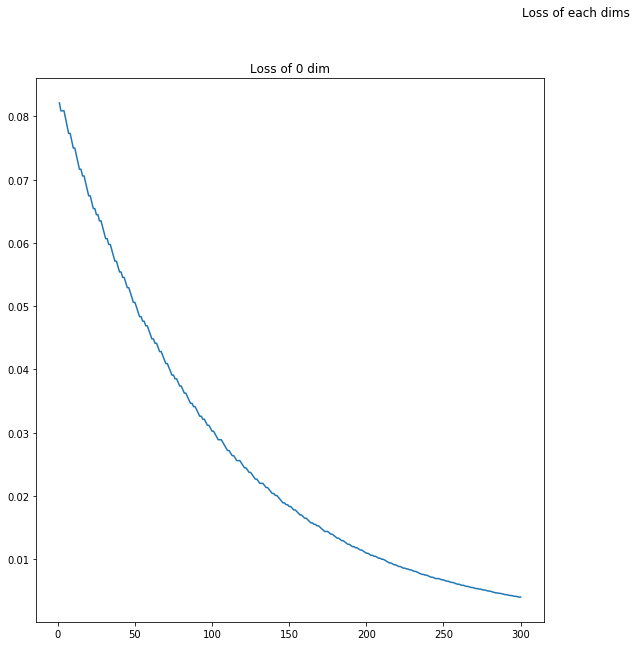

[[4 5 6]]
模型预测结果：


array([[2.00001299]])

In [3]:
# 简单测试案例
inputX = np.array([[1,2,3],[4,5,6],[7,8,9]])
outputY = np.array([[1],[2],[3]])
testX = np.array([[4,5,6]])

# 归一化对象
normXObj = PreprocessObj(inputX)
normYObj = PreprocessObj(outputY)
normInputX = normXObj.normalize_result
normOutputY = normYObj.normalize_result

# 构建 FBUObj 对象并训练
fbuObj = FBUObj(normInputX, normOutputY, max_epoch=100, batch_size=1, eps=1e-5)
fbuObj.train_model()

# 损失函数下降变化图
fbuObj.loss_image()

# 预测 testX 的值
print(testX)
print("模型预测结果：")
normTestX = normXObj.NormalInference(testX)
normYObj.ReversNormalInference(fbuObj.Inference(normTestX))

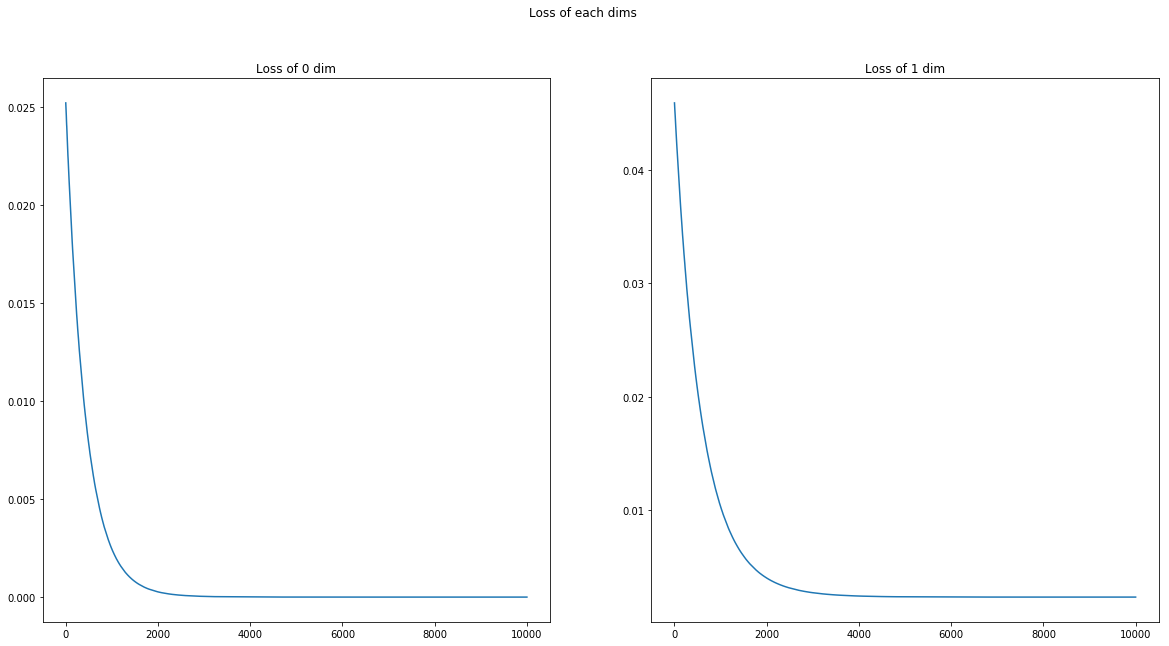

[[3 4 5 6]]
模型预测结果：


array([[   50.56851392, -1729.63357357]])

In [2]:
# 构造函数 y1 = x1 + 2 * x2 + 3 * x3 + 4 * x4 + error
# 构造函数 y2 = ln(x1) + x2 ** 2 - x3 ** (1/2) + x4 + error
# 对于线性的效果比较好，但是到了非线性效果很差！
sample_num = 100
inputX = np.random.random((sample_num,4))*100
oY1 = (inputX[:,0] + 2 * inputX[:,1] + 3 * inputX[:,2] + 4 * inputX[:,3] + np.random.random((sample_num)))
oY2 = (np.log(inputX[:,0]) + inputX[:,1]**2 - np.sqrt(inputX[:,2]) + inputX[:,3] + np.random.random((sample_num)))
outputY = np.column_stack((oY1,oY2))
testX = np.array([[3,4,5,6]])

# 归一化对象
normXObj = PreprocessObj(inputX)
normYObj = PreprocessObj(outputY)
normInputX = normXObj.normalize_result
normOutputY = normYObj.normalize_result

# 构建 FBUObj 对象并训练
fbuObj = FBUObj(normInputX, normOutputY, max_epoch=1000, batch_size=10, eps=1e-10)
fbuObj.train_model()

# 损失函数下降变化图
fbuObj.loss_image()

# 预测 testX 的值
print(testX)
print("模型预测结果：")
normTestX = normXObj.NormalInference(testX)
normYObj.ReversNormalInference(fbuObj.Inference(normTestX))

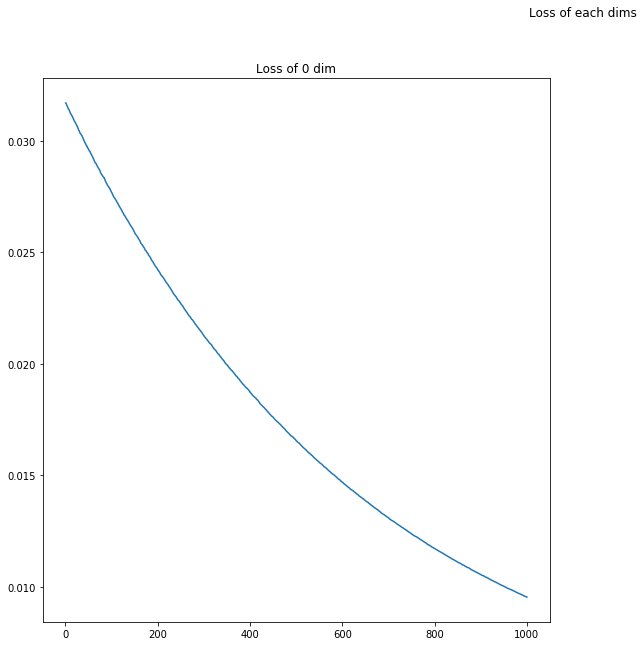

[[0.31316207]
 [0.80359171]]
模型预测结果：


array([[3.77075597],
       [4.31275114]])

In [5]:
# 读取实际文件 ch04.npz
file_name = "./Data/ch04.npz"
data = np.load(file_name)
inputX = data['data']
outputY = data['label']
testX = inputX[10:12]
testY = outputY[10:12]

# 归一化对象
normXObj = PreprocessObj(inputX)
normYObj = PreprocessObj(outputY)
normInputX = normXObj.normalize_result
normOutputY = normYObj.normalize_result

# 构建 FBUObj 对象并训练
fbuObj = FBUObj(normInputX, normOutputY, max_epoch=100, batch_size=10, eps=1e-10)
fbuObj.train_model()

# 损失函数下降变化图
fbuObj.loss_image()

# 预测 testX 的值
print(testX)
print("模型预测结果：")
normTestX = normXObj.NormalInference(testX)
normYObj.ReversNormalInference(fbuObj.Inference(normTestX))